LEVEL 21.0 — WHAT IS FAILURE? (ABSOLUTE ZERO)

A failure means:
- Something did not happen as expected

Examples in food delivery:
- Order confirmation failed
- Payment service is down
- Delivery partner assignment failed
- Worker/server crashed

In real systems, failure is NORMAL, not exception.

In [ ]:
❌ BAD SYSTEM
If failure → order lost forever

✅ GOOD SYSTEM
If failure → retry → recover → or safely store for later

LEVEL 21.1 — WHERE FAILURES HAPPEN
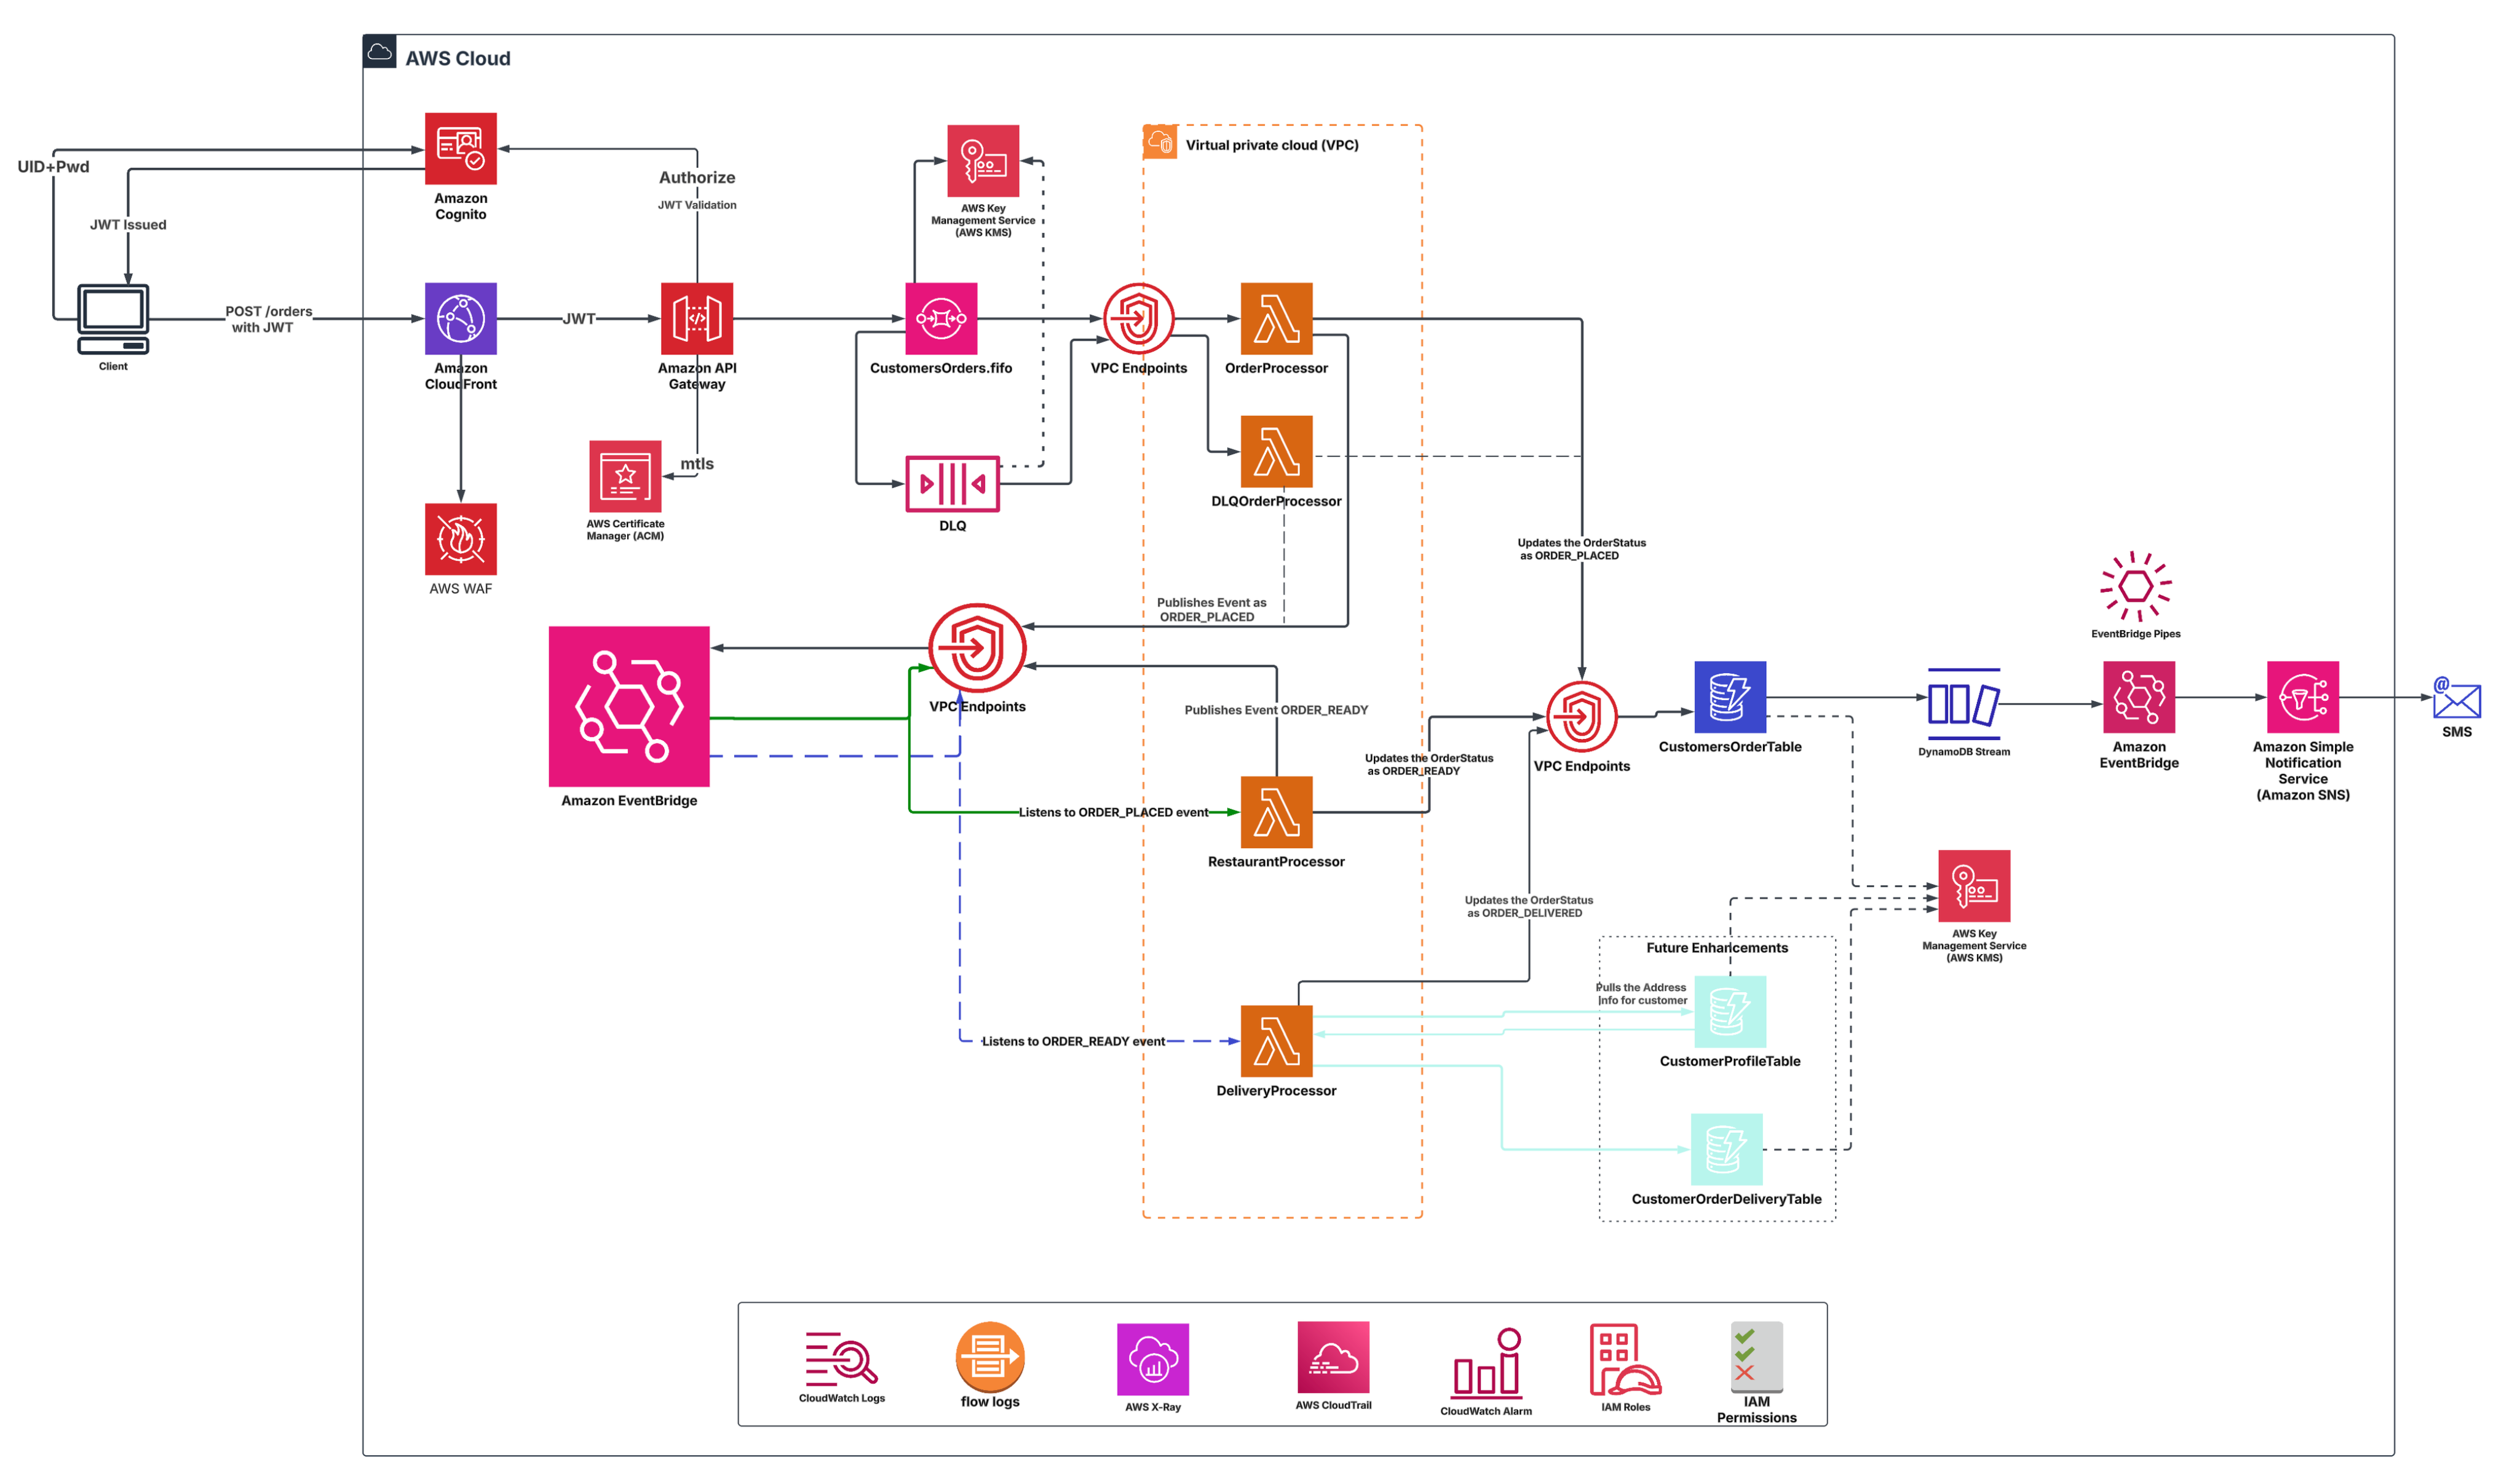

Failures can happen at:
- API server
- Message queue
- Worker
- Database
- External service (payment, maps)

LEVEL 21.2 — RETRY 

Idea (VERY SIMPLE):
- “Try again, it may work next time”

Why?
- Network glitch
- Temporary DB issue
- Worker restart

In [ ]:
# BASIC RETRY LOGIC (PURE PYTHON)
def process_order_with_retry(order, max_retries=3):
    for attempt in range(1, max_retries + 1):
        try:
            print(f"Attempt {attempt} for order {order.order_id}")

            # simulate failure
            if attempt < 3:
                raise Exception("Temporary failure")

            print("Order processed successfully")
            return True

        except Exception as e:
            print("Error:", e)

    print("All retries failed")
    return False

Meaning:
- Try multiple times
- Don’t give up immediately

LEVEL 21.3 — WHY RETRY ALONE IS NOT ENOUGH

Problem:
- Some failures are permanent
- Retrying forever wastes resources

Example:
- Invalid order data
- Restaurant closed
- Item no longer available

These will never succeed, no matter retries.

LEVEL 21.4 — DEAD LETTER QUEUE (DLQ) — VERY IMPORTANT

Simple definition:
- A Dead Letter Queue stores messages that failed permanently.
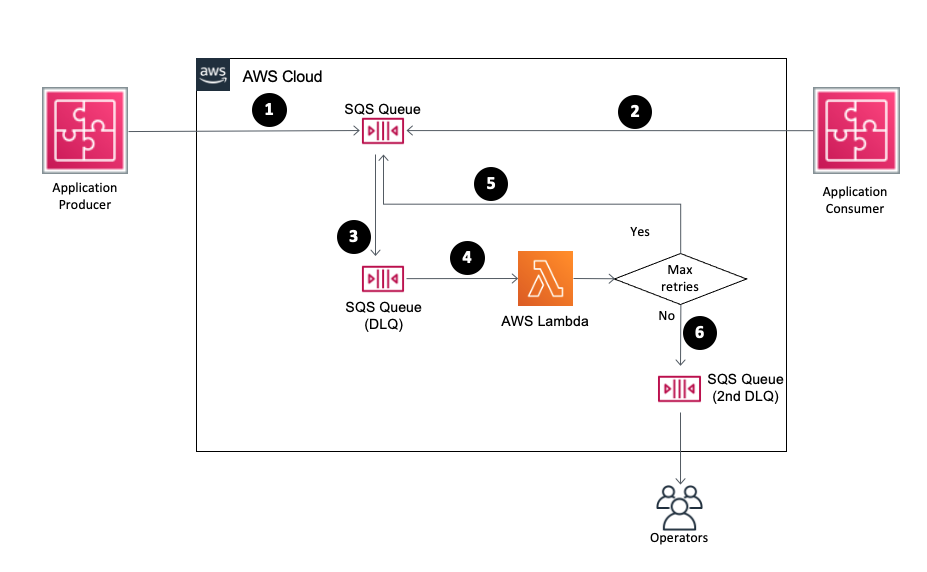
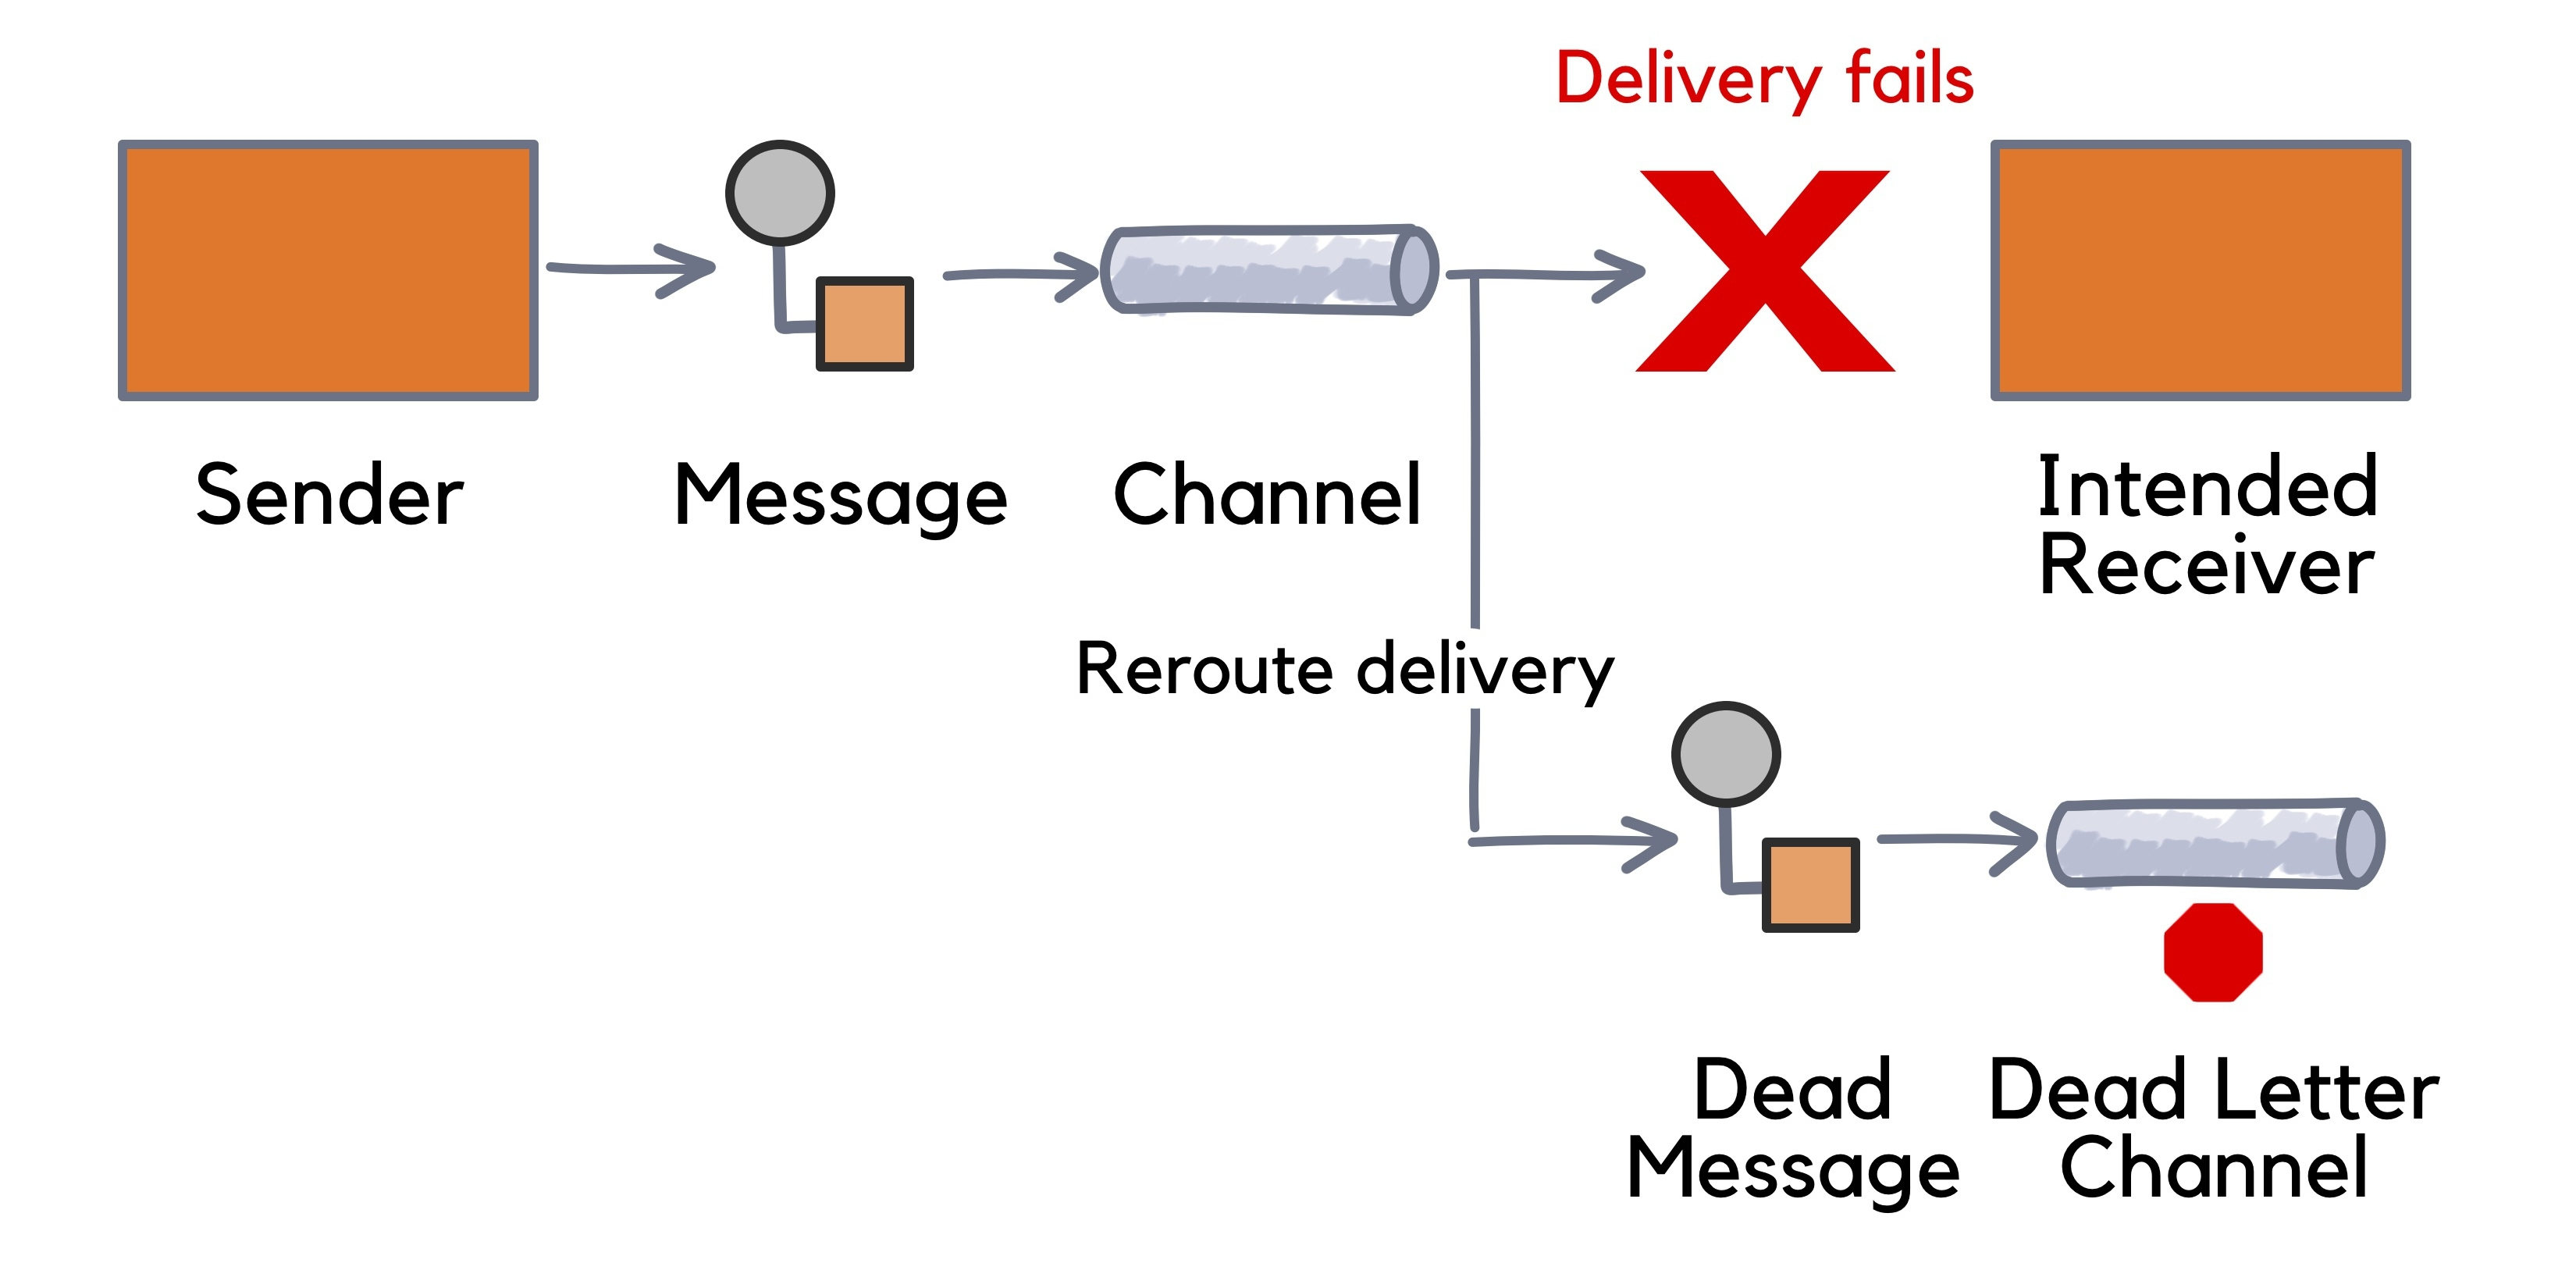

WHY DLQ EXISTS

Instead of:
- Order lost ❌

We do:
- Order → Retry → Still fails → DLQ ✅

Later:
- Engineers inspect
- fix manually
- Replay if needed

DLQ IMPLEMENTATION (PURE PYTHON)

In [ ]:
from collections import deque

class MessageQueue:
    def __init__(self):
        self.queue = deque()

    def push(self, msg):
        self.queue.append(msg)

    def pop(self):
        if self.queue:
            return self.queue.popleft()
        return None


class DeadLetterQueue:
    def __init__(self):
        self.failed = []

    def add(self, msg):
        print("Moved to DLQ:", msg.order_id)
        self.failed.append(msg)

PROCESS WITH RETRY + DLQ

In [ ]:
def worker_process(queue, dlq):
    while True:
        order = queue.pop()
        if not order:
            break

        success = process_order_with_retry(order)

        if not success:
            dlq.add(order)

## This is real production logic.

LEVEL 21.5 — IDEMPOTENCY (ADVANCED BUT SIMPLE)

Problem:
- Retry may cause duplicate processing.

Example:
- Payment charged twice ❌
- Order confirmed twice ❌

## IDEMPOTENT OPERATION
### Running the same request multiple times gives same result

IDEMPOTENCY CHECK

In [ ]:
processed_orders = set()

def safe_process(order):
    if order.order_id in processed_orders:
        print("Order already processed")
        return

    processed_orders.add(order.order_id)
    print("Processing order:", order.order_id)

Keyword interviewers love:
- Idempotency key

LEVEL 21.6 — TIMEOUTS (SILENT FAILURE PREVENTION)

Problem:
- Service keeps waiting forever.

Solution:
- Set timeout
- Fail fast
- Retry or DLQ

Conceptually:
- Wait 2 seconds → stop → retry

LEVEL 21.7 — CIRCUIT BREAKER (ADVANCED CONCEPT)

Analogy:
- If electric circuit fails → breaker trips → saves system.

#### In backend:

If a service keeps failing:
- Stop calling it temporarily
- Protect system

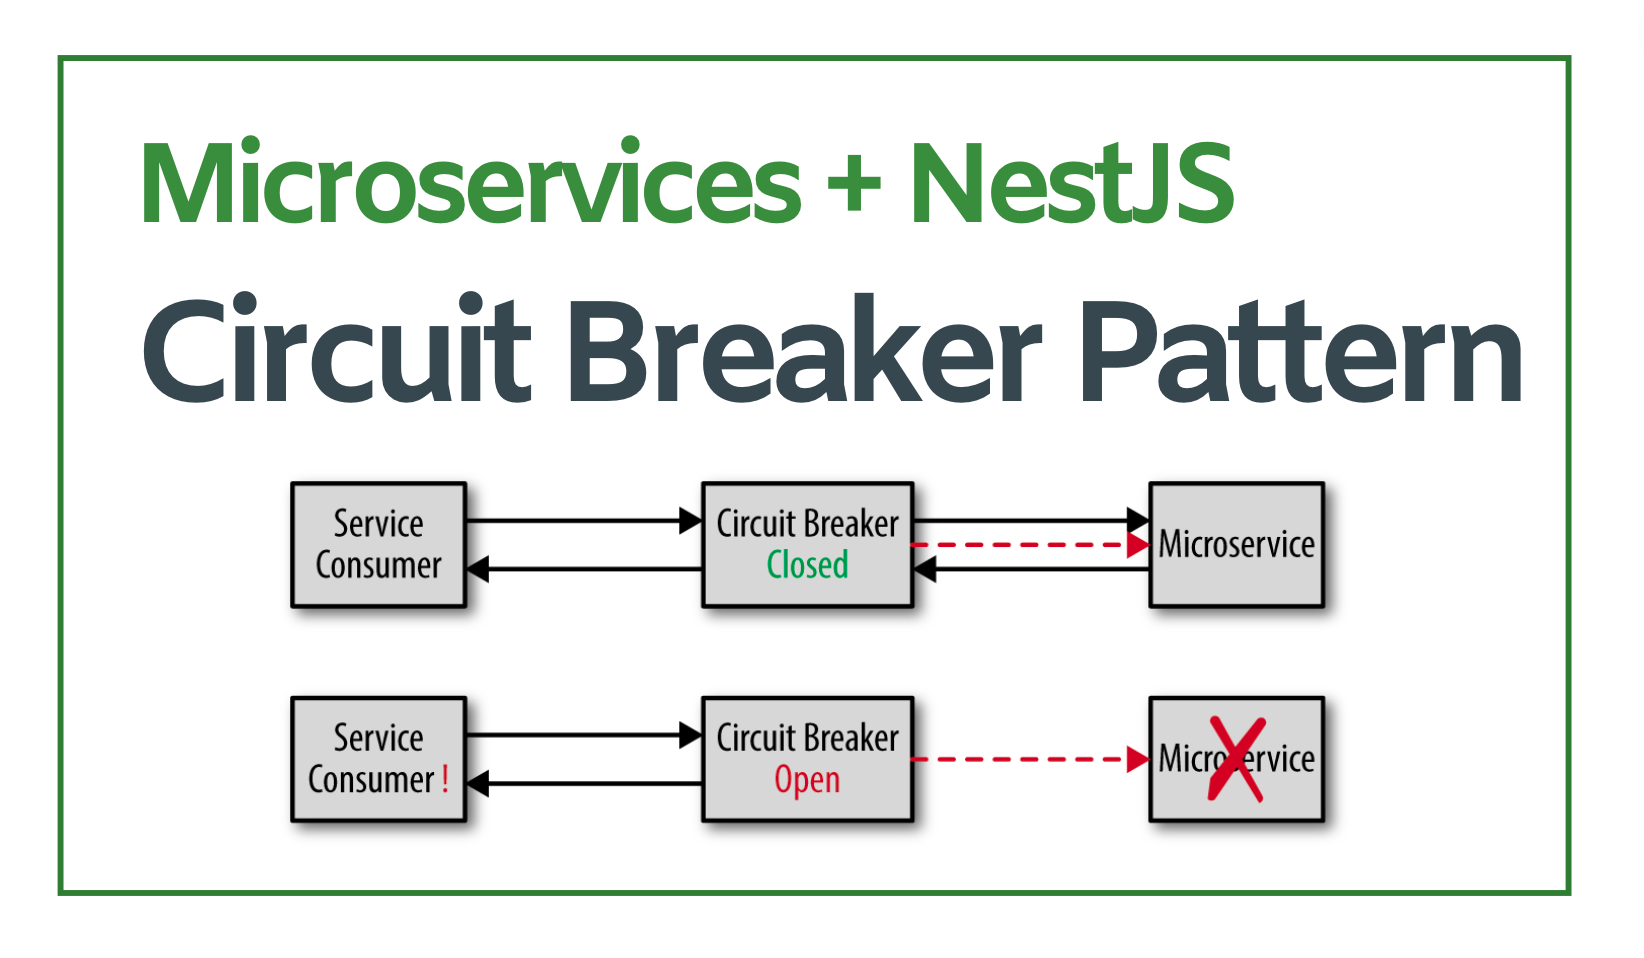
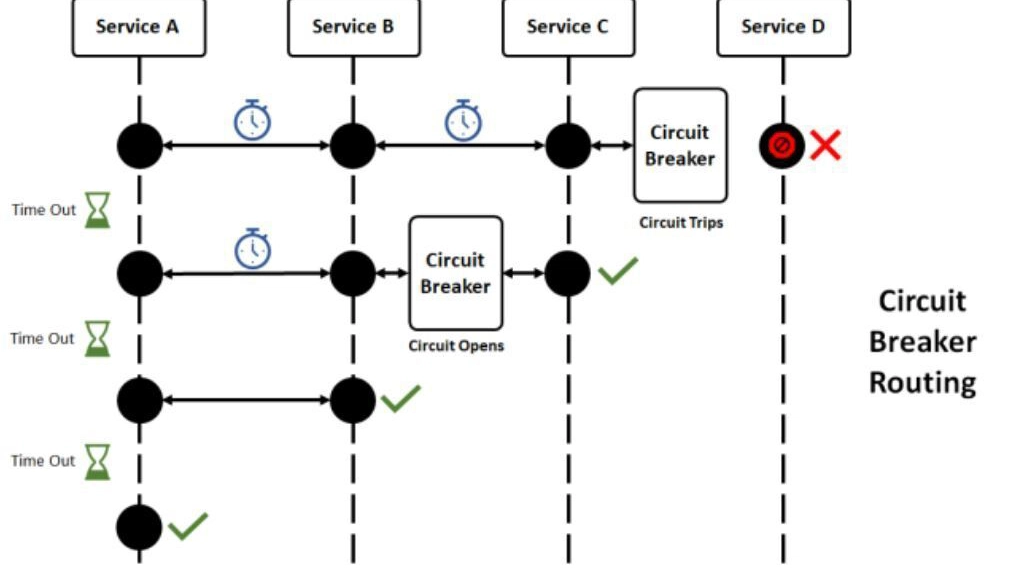

i am now understand:
- Failures are normal
- Retry logic
- Dead Letter Queue
- Idempotency
- Fault-tolerant systems

## LEVEL 21.8 — HOW SWIGGY USES THIS (REALITY)

In **Swiggy-like systems**, failures are handled using multiple resilience patterns depending on the scenario.

### 🔁 Failure Handling Scenarios

| Scenario              | What Happens            |
|-----------------------|-------------------------|
| Temporary DB issue    | Retry                   |
| Worker crash          | Message reprocessed     |
| Permanent failure     | Dead Letter Queue (DLQ) |
| Duplicate request     | Idempotency             |
| Downstream failure    | Circuit breaker         |

---

## 🧠 ONE-LINE INTERVIEW ANSWER (IMPORTANT)

> **“We handle failures using retries with limits, idempotent operations to avoid duplication, and dead-letter queues for permanently failed messages, making the system fault-tolerant.”**